#### Prompt Chaining
Prompt chaining represents one of the most fundamental agentic workflow patterns, where complex tasks are decomposed into manageable sequential steps. Each step builds upon the previous one, creating a structured approach that significantly improves accuracy by simplifying individual subtasks before progressing to the next phase.

This pattern excels in scenarios where step-by-step reasoning enhances overall output quality. Rather than overwhelming the language model with a complex, multi-faceted prompt, prompt chaining breaks down the cognitive load into digestible components, allowing for more focused and accurate processing at each stage.

#### How Prompt Chaining Works with LangGraph
1. Define the Task: Start by breaking down the problem into smaller sub-tasks. For example, if you want to generate a detailed report, you might split it into steps like "gather data," "analyze data," and "write summary."

2. Create Nodes: Each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text."

3. Establish Edges: Edges define the sequence and dependencies between nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.

4. Execute the Graph: LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.

5. Iterate if Needed: LangGraph supports conditional logic and loops, so you can revisit earlier nodes or adjust the flow based on intermediate results.

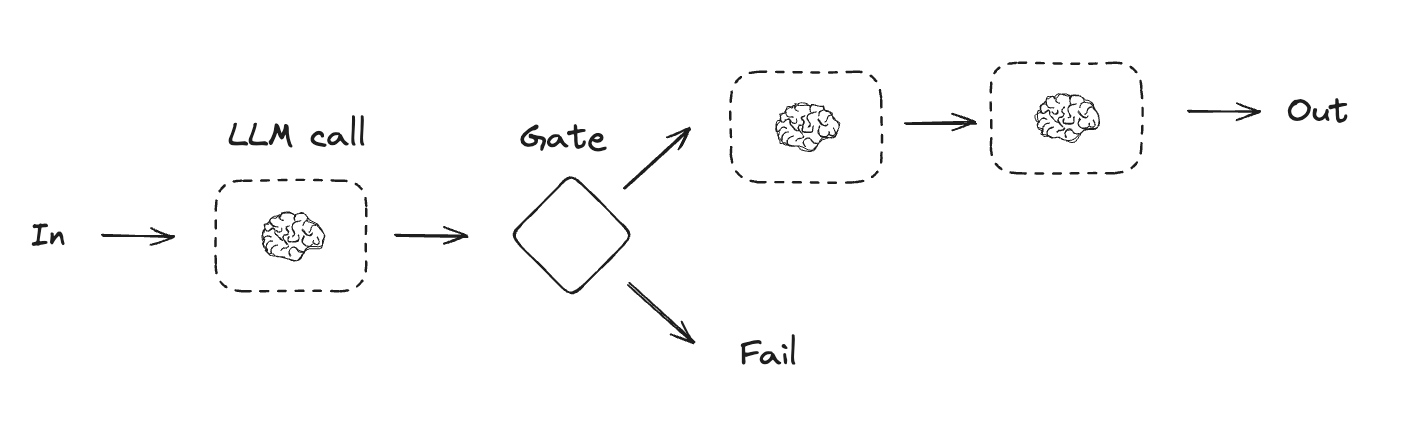



### Step 1: Setting Up the Environment


In [ ]:
from dotenv import load_dotenv
load_dotenv()

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize the language model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")


### Step 2: Defining the Workflow State

In [2]:
class EmailState(TypedDict):
    """State to track email creation progress"""
    topic: str
    key_points: str
    draft_email: str
    final_email: str

### Step 3: Creating Processing Functions

In [3]:
def extract_key_points(state: EmailState):
    """Step 1: Extract key points from the topic"""
    prompt = f"List 3 key points about: {state['topic']}"
    response = llm.invoke(prompt)
    print(f"✅ Key points extracted")
    return {"key_points": response.content}

def validate_key_points(state: EmailState):
    """Quality check: Ensure key points are actionable and specific"""
    key_points = state["key_points"]
    
    # Check for actionable words and specific content
    actionable_words = ['request', 'need', 'require', 'propose', 'suggest', 'recommend', 'deadline', 'schedule', 'meeting', 'discuss', 'review', 'approve', 'extension', 'support', 'assistance', 'feedback', 'update', 'status', 'progress', 'complete', 'deliver']
    
    # Convert to lowercase for checking
    points_lower = key_points.lower()
    
    # Count actionable words found
    actionable_count = sum(1 for word in actionable_words if word in points_lower)
    
    # Also check minimum length (should be substantial)
    word_count = len(key_points.split())
    
    if actionable_count >= 2 and word_count >= 15:
        print(f"✅ Key points validation: PASSED (Found {actionable_count} actionable words, {word_count} total words)")
        return "proceed"
    else:
        print(f"❌ Key points validation: FAILED (Only {actionable_count} actionable words, {word_count} total words) - regenerating...")
        return "regenerate"

def write_draft(state: EmailState):
    """Step 2: Write email draft using key points"""
    prompt = f"Write a professional email draft covering these points: {state['key_points']}"
    response = llm.invoke(prompt)
    print(f"✅ Draft written")
    return {"draft_email": response.content}

def polish_email(state: EmailState):
    """Step 3: Polish and add proper formatting"""
    prompt = f"Polish this email and add proper greeting/closing: {state['draft_email']}"
    response = llm.invoke(prompt)
    print(f"✅ Email polished")
    return {"final_email": response.content}

### Step 4: Building the Sequential Workflow

In [4]:
# Create the workflow graph
workflow = StateGraph(EmailState)

# Add processing nodes
workflow.add_node("extract_points", extract_key_points)
workflow.add_node("write_draft", write_draft)
workflow.add_node("polish_final", polish_email)

# Connect nodes with conditional logic
workflow.add_edge(START, "extract_points")
workflow.add_conditional_edges(
    "extract_points", 
    validate_key_points, 
    {
        "proceed": "write_draft",
        "regenerate": "extract_points"
    }
)
workflow.add_edge("write_draft", "polish_final")
workflow.add_edge("polish_final", END)

# Compile the workflow
compiled_workflow = workflow.compile()

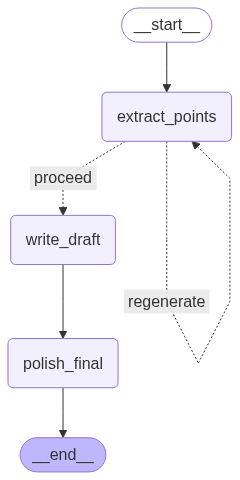

In [5]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        compiled_workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Step 5: Running the Workflow with Test Cases

In [7]:
# Execute the email creation process
def create_email(topic: str):
    """Run the complete email creation workflow"""
    print(f"📧 Creating email about: '{topic}'")
    print("-" * 40)
    
    result = compiled_workflow.invoke({"topic": topic})
    
    print("\n🎉 Email creation completed!")
    return result["final_email"]


In [ ]:

# Test Case 1: Should pass validation (specific, detailed topic)
print("🧪 TEST CASE 1: Detailed Topic (Should Pass)")
email1 = create_email("Request for project deadline extension due to technical challenges")
print(f"\n📄 FINAL EMAIL:\n{email1}")


🧪 TEST CASE 1: Detailed Topic (Should Pass)
📧 Creating email about: 'Request for project deadline extension due to technical challenges'
----------------------------------------
✅ Key points extracted
✅ Key points validation: PASSED (Found 7 actionable words, 200 total words)
✅ Draft written
✅ Email polished

🎉 Email creation completed!

📄 FINAL EMAIL:
Subject: Request for Extension - [Project Name] - [Deliverable/Phase Affected]

Dear [Recipient Name],

This email is to formally request an extension for the deadline of [Deliverable/Phase Affected] within the [Project Name] project, currently scheduled for [Original Deadline]. We have encountered unforeseen technical challenges that are impacting our progress and require additional time to resolve.

Specifically, we have experienced [Clearly Explain the Specific Technical Challenge(s) - e.g., "unexpected incompatibility between the new database and the legacy system when attempting to migrate user data." or "unforeseen limitations in t

In [8]:
# Test Case 2: Should fail validation (abstract/philosophical topic)
print("🧪 TEST CASE 2: Abstract Topic (Should Fail & Regenerate)")
email2 = create_email("The meaning of life and happiness")
print(f"\n📄 FINAL EMAIL:\n{email2}")

🧪 TEST CASE 2: Abstract Topic (Should Fail & Regenerate)
📧 Creating email about: 'The meaning of life and happiness'
----------------------------------------
✅ Key points extracted
❌ Key points validation: FAILED (Only 0 actionable words, 233 total words) - regenerating...
✅ Key points extracted
✅ Key points validation: PASSED (Found 2 actionable words, 207 total words)
✅ Draft written
✅ Email polished

🎉 Email creation completed!

📄 FINAL EMAIL:
Subject: Thoughts on Meaning, Happiness, and Well-being

Dear [Recipient Name],

I hope this email finds you well.

I've been reflecting lately on the concepts of meaning and happiness, and wanted to share a few key thoughts that have resonated with me. I recognize these are vast and subjective topics, but I believe they're important to consider for our overall well-being.

Firstly, it seems clear that **meaning and happiness are often interconnected, but not synonymous.** While a sense of purpose and meaning can significantly contribute to lo